<a href="https://colab.research.google.com/github/ViniTelheiro/GANs/blob/main/WGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import time
from IPython import display
from tensorflow import keras
from tensorflow.keras import layers


#Loading and preprocessing the images:


In [3]:
(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [5]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')

In [6]:
x_train = (x_train - 127.5)/127.5

In [7]:
buffer_size = y_train.shape[0]
batch_size = 256

x_train = tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size).batch(batch_size)

#Build WGAN class:

In [8]:
class Generator():
  def create_generator(self):
      network = tf.keras.Sequential()

      network.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
      network.add(layers.BatchNormalization())
      network.add(layers.LeakyReLU())

      network.add(layers.Reshape((7,7,256)))

      network.add(layers.Conv2DTranspose(filters=128, kernel_size=(5,5), padding='same', use_bias=False))
      network.add(layers.BatchNormalization())
      network.add(layers.LeakyReLU())

      network.add(layers.Conv2DTranspose(filters=64, kernel_size=(5,5), padding='same', use_bias=False, strides=(2,2)))
      network.add(layers.BatchNormalization())
      network.add(layers.LeakyReLU())
      
      network.add(layers.Conv2DTranspose(filters=1, kernel_size=(5,5), use_bias=False, strides=(2,2), padding='same', activation='tanh'))
      
      return network
    

  def generator_loss(self, fake_output):
    g_loss = -1*tf.math.reduce_mean(fake_output)
    return g_loss

In [9]:
class Discriminator():
  def create_discriminator(self):
    network = tf.keras.Sequential()

    network.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=(28,28,1)))
    network.add(layers.LeakyReLU())
    network.add(layers.Dropout(.3))

    network.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    network.add(layers.LeakyReLU())
    network.add(layers.Dropout(.3))

    network.add(layers.Flatten())
    network.add(layers.Dense(1))

    return network

  def discriminator_loss(self, real_output, fake_output, gradient_penalty):
    c_lambda = 10
    d_loss = tf.math.reduce_mean(fake_output) - tf.math.reduce_mean(real_output) + c_lambda * gradient_penalty
    return d_loss




In [22]:
class WGAN_GP(Generator, Discriminator):
  def __init__(self):
    self.generator = self.create_generator()
    self.discriminator = self.create_discriminator()
    
    self.generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=.5, beta_2=.9)
    self.discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=.5, beta_2=.9)

    self.checkpoint_dir ='./training_checkpoints'
    if not os.path.isdir(self.checkpoint_dir):
      os.makedirs(self.checkpoint_dir)

    self.checkpoint = tf.train.Checkpoint(gen_optimizer=self.generator_optimizer,
                                          disc_optimizer=self.discriminator_optimizer,
                                          gen = self.generator, disc = self.discriminator)
    
    self.__seed = tf.random.normal([sample_num, noise_dim])

  @tf.function
  def gradient_penalty(self, real, fake, epsilon):
    interpolated_img = real*epsilon + fake * (1-epsilon)
    with tf.GradientTape() as tape:
      tape.watch(interpolated_img)
      scores = self.discriminator(interpolated_img)
    gradient = tape.gradient(scores, interpolated_img)[0]
    gradient_norm = tf.norm(gradient)
    gp = tf.math.reduce_mean((gradient_norm-1)**2)
    return gp
  

  def training_step(self, imgs, batch_size:int):
    noise = tf.random.normal([batch_size, 100])
    discriminator_extra_steps = 3
    for i in range(discriminator_extra_steps):
      with tf.GradientTape() as d_tape:
        generated_imgs = self.generator(noise, training=True)
        real_output = self.discriminator(imgs, training=True)
        fake_output = self.discriminator(generated_imgs, training=True)
        epsilon = tf.random.normal([batch_size, 1, 1, 1])
        gp = self.gradient_penalty(real=imgs, fake=generated_imgs, epsilon=epsilon)

        d_loss = self.discriminator_loss(real_output=real_output, fake_output=fake_output, gradient_penalty=gp)
      
      discriminators_gradient = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
      self.discriminator_optimizer.apply_gradients(zip(discriminators_gradient, self.discriminator.trainable_variables))

    with tf.GradientTape() as g_tape:
      generated_img = self.generator(noise, training=True)
      fake_output = self.discriminator(generated_img, training=True)
      g_loss = self.generator_loss(fake_output)

    generator_gradients = g_tape.gradient(g_loss, self.generator.trainable_variables)
    self.generator_optimizer.apply_gradients(zip(generator_gradients, self.generator.trainable_variables))


  def __generate_and_save_imgs(self, model ,epoch, test_input):
    preds = model(test_input, training=False)
    fig = plt.figure(figsize=(4,4))
    for i in range(preds.shape[0]):
      plt.subplot(4,4,i+1)
      plt.imshow(preds[i,:,:,0]*127.5+127.5, cmap='gray')
      plt.axis('off')
    plt.savefig(f'img_epoch_{epoch:04d}.png')
    plt.show()

  def trainer(self, dataset, epochs:int, batch_size:int):
    for epoch in range(epochs):
      i = time.time()
      for img_batch in dataset:
        if len(img_batch) == batch_size:
          self.training_step(img_batch, batch_size)
      display.clear_output(wait=True)
      self.__generate_and_save_imgs(self.generator, epoch+1, self.__seed)
      if (epoch + 1) % 10 == 0:
        self.checkpoint.save(file_prefix=self.checkpoint_dir)
      print(f'Running Time for epoch {epoch+1}: {time.time() - i} seconds')
      
    display.clear_output(wait=True)
    self.__generate_and_save_imgs(self.generator, epochs, self.__seed)
    self.generator.save('generator.h5') 

    

In [24]:
epochs = 30
noise_dim = 100
sample_num = 16


In [25]:
wgan = WGAN_GP()

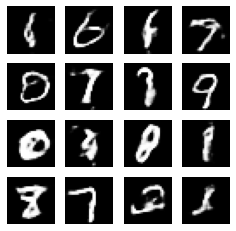

In [26]:
wgan.trainer(dataset=x_train, epochs=epochs, batch_size=batch_size)

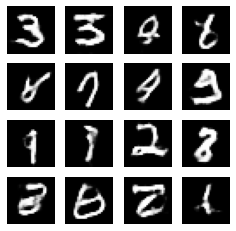

In [27]:
seed_input = tf.random.normal([sample_num, noise_dim])
preds = wgan.generator(seed_input, training=False)
fig = plt.figure(figsize=(4,4))
for i in range(preds.shape[0]):
  plt.subplot(4,4,i+1)
  plt.imshow(preds[i,:,:,0]*127.5+127.5, cmap='gray')
  plt.axis('off')